In [237]:
import os
import time
import requests
import sys
from bs4 import BeautifulSoup
import csv
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# function to retrieve data from https://en.tutiempo.net/climate/12-2000/ws-725030.html
# scrape the data for past 20 years

def get_html():
    for year in range(2000, 2021):
        for month in range(1, 13):
            if month < 10:
                url = f'https://en.tutiempo.net/climate/0{month}-{year}/ws-725030.html'
            else:
                url = f'https://en.tutiempo.net/climate/{month}-{year}/ws-725030.html'
                
            texts = requests.get(url)
            text_utf = texts.text.encode("utf=8")

            if not os.path.exists(f'data/data_html/{year}'):
                os.makedirs(f'data/data_html/{year}')

            with open(f'data/data_html/{year}/{month}.html', "wb") as output:
                output.write(text_utf)
        
        sys.stdout.flush()
        

In [8]:
# check the time taken to retrieve data
start_time = time.time()
get_html()
end_time = time.time()
print(f"Time taken {end_time-start_time}")

Time taken 366.71296429634094


In [89]:
# convert date to datetime and find mean value per day
def convert_data():
    for file_name in range(2000, 2021):
        url = f'data/aqi_2000-2020/aqi_{file_name}.csv'
        df = pd.read_csv(url)
        df['Date_time'] = pd.to_datetime(df["Date"]).dt.date
        df = df.groupby(df['Date_time']).mean()
        df.to_csv(f'data/processing/{file_name}.csv')
                

In [90]:
convert_data()

In [92]:
df_2000 = pd.read_csv("data/processing/2000.csv")
df_2005 = pd.read_csv("data/processing/2005.csv")
df_2010 = pd.read_csv("data/processing/2010.csv")
df_2020 = pd.read_csv("data/processing/2020.csv")

In [198]:
df_2010['Daily_Mean_PM2.5_Concentration'][0]

23.946666666666665

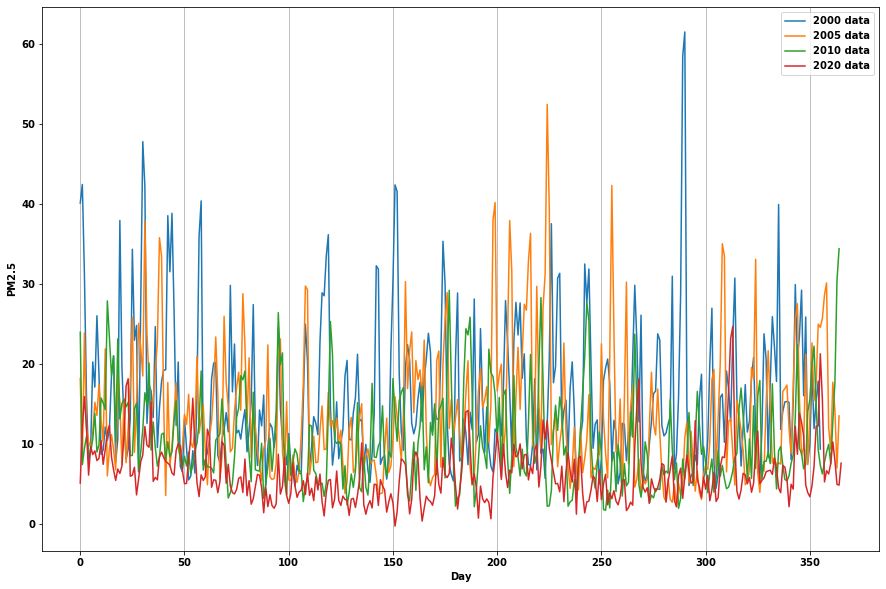

In [301]:
# plot some data 
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(range(0, 356), df_2000['Daily_Mean_PM2.5_Concentration'], label="2000 data")
plt.plot(range(0, 365), df_2005['Daily_Mean_PM2.5_Concentration'], label="2005 data")
plt.plot(range(0, 365), df_2010['Daily_Mean_PM2.5_Concentration'], label="2010 data")
plt.plot(range(0, 366), df_2020['Daily_Mean_PM2.5_Concentration'], label="2020 data")

plt.figsize=(10,15)
plt.xlabel("Day")
plt.ylabel("PM2.5")
plt.grid(axis='x')
plt.legend(loc="upper right")
plt.show()


In [302]:
def met_data(month, year):
    file_html = open(f"data/data_html/{year}/{month}.html", "rb")
    plain_text = file_html.read()
    
    tempD = []
    finalD = []
    
    soup = BeautifulSoup(plain_text, "html.parser")
    for table in soup.findAll("table", {"class": "medias mensuales numspan"}):
        for tbody in table:
            for tr in tbody:
                a = tr.get_text()
                if a == '\xa0' or a == '-':
                    a = np.nan
                if a == 'o':
                    a = 1
                tempD.append(a)
                          
    rows = len(tempD) / 15
    
    for times in range(round(rows)):
        newTempD = []
        for i in range(15):
            newTempD.append(tempD[0])
            tempD.pop(0)
        finalD.append(newTempD)
    
    finalD.pop(len(finalD) - 1)
    finalD.pop(0)
    
    for a in range(len(finalD)):
        finalD[a].pop(0)
        finalD[a].pop(9)
        
    return finalD
        

In [303]:
if not os.path.exists("data/cleaned-data"):
    os.makedirs("data/cleaned-data")
for year in range(2000, 2021):
    final_data = []
    with open('data/cleaned-data/cleaned_' + str(year) + '.csv', 'w') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        wr.writerow(
            ['AvgTemp', 'MaxTemp', 'MinTemp', 'SeaLevelPressure', 'AvgHumidity', 'TotalRainfallSnowmelt', 'AvgVisibility', 'AvgWindSpeed',
             'MaxWindSpeed', 'RainDrizzle', 'Snow', 'ThunderStorm', 'Fog', 'PM 2.5'])
    
    for month in range(1, 13):
        temp = met_data(month, year)
        final_data = final_data + temp
        
    for i in range(len(final_data)):
        df = pd.read_csv(f'data/processing/{year}.csv')
        if len(df) > i:
            final_data[i].append(df['Daily_Mean_PM2.5_Concentration'][i])
        else:
            final_data[i].append("-")
            
# remove rows with emplty data
    with open('data/cleaned-data/cleaned_' + str(year) + '.csv', 'a') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        for row in final_data:
            flag = 0
            for elem in row:
                if elem == "" or elem == "-":
                    flag = 1
            if flag != 1:
                wr.writerow(row)
        

In [304]:
all_files = sorted(glob("data/cleaned-data/cleaned_*.csv"))
real_data = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)

In [307]:
pd.options.display.max_rows = 999
real_data = real_data[:3919]

In [309]:
real_data.isnull().sum()

AvgTemp                    45
MaxTemp                    45
MinTemp                    45
SeaLevelPressure           46
AvgHumidity                51
TotalRainfallSnowmelt      76
AvgVisibility              45
AvgWindSpeed               45
MaxWindSpeed               45
RainDrizzle              2467
Snow                     3649
ThunderStorm             3678
Fog                      3739
PM 2.5                      0
dtype: int64

In [310]:
# remove rows where there is no data
real_data = real_data[real_data['AvgTemp'].notna()]

In [311]:
real_data.isna().sum()

AvgTemp                     0
MaxTemp                     0
MinTemp                     0
SeaLevelPressure            1
AvgHumidity                 6
TotalRainfallSnowmelt      31
AvgVisibility               0
AvgWindSpeed                0
MaxWindSpeed                0
RainDrizzle              2422
Snow                     3604
ThunderStorm             3633
Fog                      3694
PM 2.5                      0
dtype: int64

In [312]:
real_data.head(30)

,AvgTemp,MaxTemp,MinTemp,SeaLevelPressure,AvgHumidity,TotalRainfallSnowmelt,AvgVisibility,AvgWindSpeed,MaxWindSpeed,RainDrizzle,Snow,ThunderStorm,Fog,PM 2.5
0,4.3,10.0,1.7,1023.1,94.0,0.00,8.0,13.0,22.2,NaN,NaN,NaN,NaN,40.080000
1,8.8,14.4,1.7,1021.4,89.0,0.00,10.3,8.9,20.6,NaN,NaN,NaN,NaN,42.400000
2,14.3,17.2,5.0,1016.6,84.0,0.76,12.4,15.2,24.1,NaN,NaN,NaN,NaN,31.250000
3,5.8,9.4,-2.2,1023.8,70.0,0.00,15.6,17.0,38.9,NaN,NaN,NaN,NaN,20.227273
4,2.1,4.0,-1.0,1025.9,49.0,0.00,16.1,20.9,29.4,NaN,NaN,NaN,NaN,17.100000
5,6.0,10.0,-0.6,1019.5,62.0,0.00,16.1,14.6,25.9,1.0,NaN,NaN,NaN,26.000000
6,2.4,6.7,-3.0,1014.5,65.0,0.25,13.7,19.4,44.3,NaN,1.0,NaN,NaN,12.120000
7,-6.7,4.4,-9.4,1026.7,50.0,0.00,16.1,40.0,51.9,NaN,NaN,NaN,NaN,10.400000
8,-6.1,-2.0,-8.0,1036.2,50.0,0.00,16.1,21.3,42.4,NaN,NaN,NaN,NaN,11.890000
9,-7.1,-1.0,-12.0,1013.1,45.0,0.00,16.1,16.1,24.1,NaN,NaN,NaN,NaN,10.590000


In [313]:
real_data.describe()

,AvgTemp,MaxTemp,MinTemp,SeaLevelPressure,AvgHumidity,TotalRainfallSnowmelt,AvgVisibility,AvgWindSpeed,MaxWindSpeed,RainDrizzle,Snow,ThunderStorm,Fog,PM 2.5
count,3874.000000,3874.000000,3874.000000,3873.000000,3868.000000,3843.000000,3874.000000,3874.000000,3874.000000,1452.0,270.0,241.0,180.0,3874.000000
mean,13.532008,18.714146,9.283092,1016.533617,59.814891,3.325928,14.779763,17.091843,29.647522,1.0,1.0,1.0,1.0,10.848847
std,9.588658,10.060101,9.394427,7.431114,14.824388,8.844667,2.361732,6.184301,9.105277,0.0,0.0,0.0,0.0,7.211187
min,-13.200000,-8.900000,-17.200000,982.900000,20.000000,0.000000,1.000000,3.300000,11.100000,1.0,1.0,1.0,1.0,-0.266667
25%,5.800000,10.600000,2.000000,1011.800000,49.000000,0.000000,14.500000,12.800000,22.200000,1.0,1.0,1.0,1.0,5.989833
50%,13.800000,19.400000,9.400000,1016.400000,59.000000,0.000000,16.100000,15.900000,27.800000,1.0,1.0,1.0,1.0,8.950000
75%,22.200000,27.800000,17.800000,1021.300000,70.000000,1.780000,16.100000,20.400000,35.200000,1.0,1.0,1.0,1.0,13.542083
max,33.900000,40.000000,30.000000,1042.300000,99.000000,123.950000,17.400000,47.800000,72.200000,1.0,1.0,1.0,1.0,53.450000


In [316]:
# replace nan values with mean or zero in some cases
real_data['TotalRainfallSnowmelt'].fillna(float(0), inplace=True)
real_data['Snow'].fillna(float(0), inplace=True)
real_data['ThunderStorm'].fillna(float(0), inplace=True)
real_data['Fog'].fillna(float(0), inplace=True)
real_data['RainDrizzle'].fillna(float(0), inplace=True)
real_data['SeaLevelPressure'].fillna((real_data['SeaLevelPressure'].mean()), inplace=True)
real_data['AvgHumidity'].fillna((real_data['AvgHumidity'].mean()), inplace=True)

In [317]:
real_data.isna().sum()

AvgTemp                  0
MaxTemp                  0
MinTemp                  0
SeaLevelPressure         0
AvgHumidity              0
TotalRainfallSnowmelt    0
AvgVisibility            0
AvgWindSpeed             0
MaxWindSpeed             0
RainDrizzle              0
Snow                     0
ThunderStorm             0
Fog                      0
PM 2.5                   0
dtype: int64

In [318]:
real_data.shape

(3874, 14)

In [321]:
real_data.to_csv("data/combined_data/combined_data.csv", index=False)

In [322]:
df = pd.read_csv("data/combined_data/combined_data.csv", )
df.head()

,AvgTemp,MaxTemp,MinTemp,SeaLevelPressure,AvgHumidity,TotalRainfallSnowmelt,AvgVisibility,AvgWindSpeed,MaxWindSpeed,RainDrizzle,Snow,ThunderStorm,Fog,PM 2.5
0,4.3,10.0,1.7,1023.1,94.0,0.00,8.0,13.0,22.2,0.0,0.0,0.0,0.0,40.080000
1,8.8,14.4,1.7,1021.4,89.0,0.00,10.3,8.9,20.6,0.0,0.0,0.0,0.0,42.400000
2,14.3,17.2,5.0,1016.6,84.0,0.76,12.4,15.2,24.1,0.0,0.0,0.0,0.0,31.250000
3,5.8,9.4,-2.2,1023.8,70.0,0.00,15.6,17.0,38.9,0.0,0.0,0.0,0.0,20.227273
4,2.1,4.0,-1.0,1025.9,49.0,0.00,16.1,20.9,29.4,0.0,0.0,0.0,0.0,17.100000
